In [1]:
import pandas as pd
import numpy as np
from datasets import load_from_disk


In [2]:
aug_stream_data = load_from_disk("data/processed/aug_stream_data")


In [3]:
aug_stream_data.set_format(type="pandas")
train_df = aug_stream_data["train"][:]
valid_df = aug_stream_data["validation"][:]


In [4]:
X_train, y_train = train_df["text"], train_df["label"]
X_valid, y_valid = valid_df["text"], valid_df["label"]
labels = aug_stream_data["train"].features["label"].names


In [5]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
X_train_embed = model.encode(X_train, show_progress_bar=True)


Batches:   0%|          | 0/346 [00:00<?, ?it/s]

In [6]:
X_valid_embed = model.encode(X_valid, show_progress_bar=True)


Batches:   0%|          | 0/44 [00:00<?, ?it/s]

In [7]:
X_train_embed.shape, X_valid_embed.shape


((11054, 768), (1382, 768))

In [8]:
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.utils.extmath import density
from time import time

def benchmark(clf, custom_name=False):
    print("_" * 80)
    print("Training: ")
    print(clf)
   
    t0 = time()
    clf.fit(X_train_embed, y_train)
    train_time = time() - t0
    print(f"train time: {train_time:.3}s")

    t0 = time()
    pred = clf.predict(X_valid_embed)
    test_time = time() - t0
    print(f"inference time:  {test_time:.3}s")

    balanced_accuracy = balanced_accuracy_score(y_valid, pred)
    print(f"Balanced accuracy score:    {balanced_accuracy:.3}")

    macro_f1 = f1_score(y_valid, pred, average="macro")
    print(f"Macro F1 score:    {macro_f1:.3}")

    weighted_f1 = f1_score(y_valid, pred, average="weighted")
    print(f"Weighted F1 score:    {weighted_f1:.3}")

    if hasattr(clf, "coef_"):
        print(f"dimensionality: {clf.coef_.shape[1]}")
        print(f"density: {density(clf.coef_)}")
        print()
    
    print()
    if custom_name:
        clf_descr = str(custom_name)
    else:
        clf_descr = clf.__class__.__name__
    return clf_descr, balanced_accuracy, macro_f1, weighted_f1, train_time, test_time


In [9]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

results = []
for clf, name in (
    (LogisticRegression(class_weight="balanced"), "Logistic Regression"),
    (RidgeClassifier(class_weight="balanced"), "Ridge Classifier"),
    (KNeighborsClassifier(), "kNN"),
    (RandomForestClassifier(class_weight="balanced"), "RandomForest Classifier"),
    (LinearSVC(class_weight="balanced"), "Linear SVC"),
    (SGDClassifier(class_weight="balanced"), "SGD Classifier"),
    (NearestCentroid(), "NearestCentroid"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf, name))
    

Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression(class_weight='balanced')
train time: 34.2s
inference time:  0.0309s
Balanced accuracy score:    0.773
Macro F1 score:    0.721
Weighted F1 score:    0.793
dimensionality: 768
density: 1.0


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(class_weight='balanced')
train time: 0.254s
inference time:  0.025s
Balanced accuracy score:    0.771
Macro F1 score:    0.703
Weighted F1 score:    0.784
dimensionality: 768
density: 1.0


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier()
train time: 0.0199s
inference time:  0.376s
Balanced accuracy score:    0.721
Macro F1 score:    0.722
Weighted F1 score:    0.811

RandomForest Classifier
________________________________________________________________________________
Training

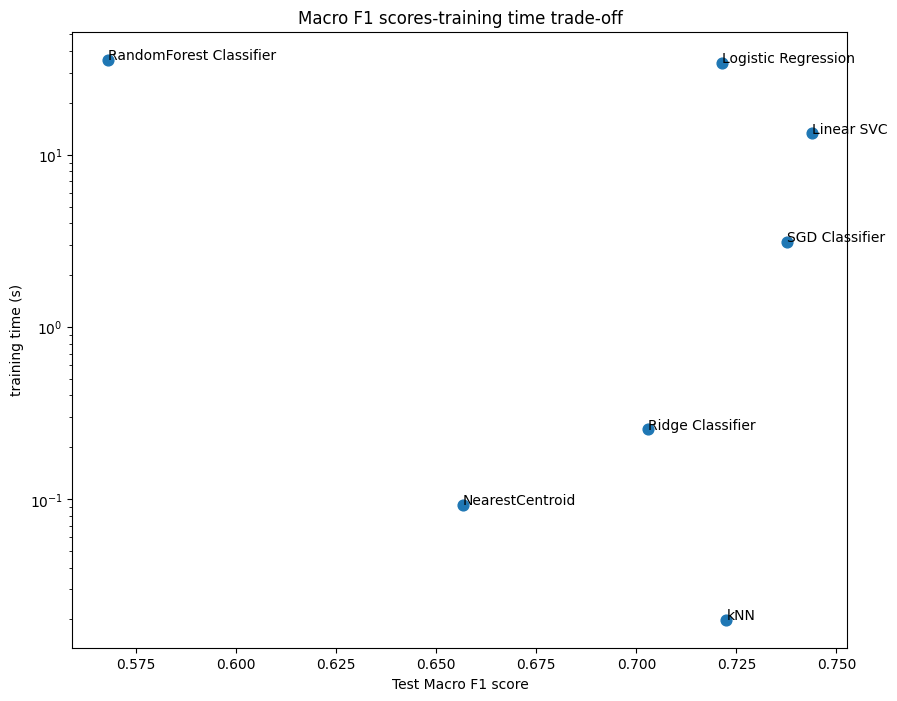

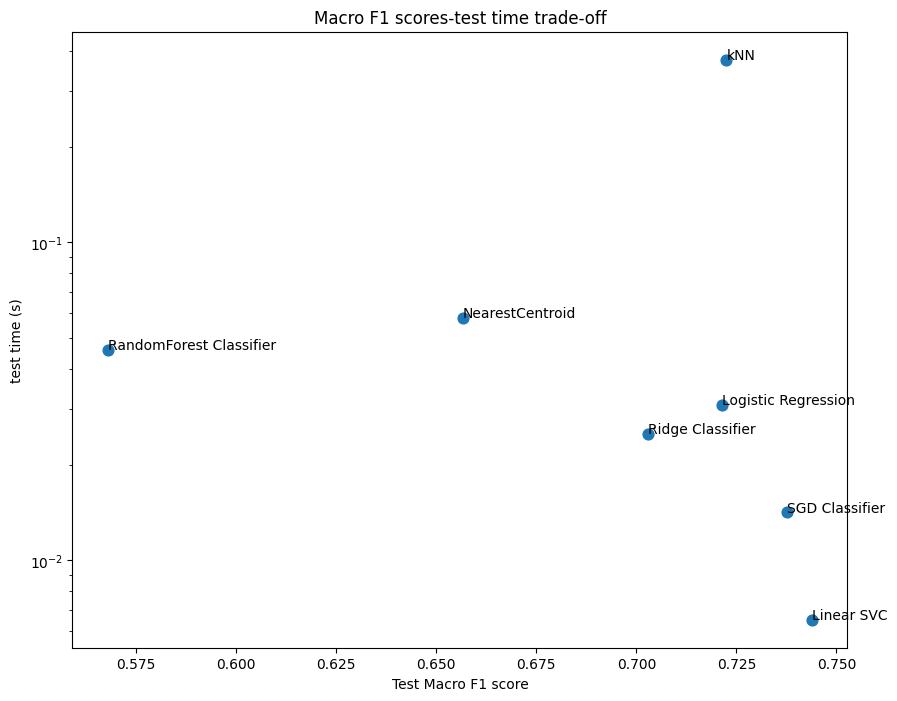

In [10]:
import numpy as np
import matplotlib.pyplot as plt  # Make sure matplotlib is imported

indices = np.arange(len(results))

# Extract all 5 elements from the results
results = [[x[i] for x in results] for i in range(6)]

# Unpack all 5 elements
clf_names, balanced_accuracy_scores, macro_f1_scores, weighted_f1_scores, training_time, test_time = results
training_time = np.array(training_time)
test_time = np.array(test_time)

fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.scatter(macro_f1_scores, training_time, s=60)
ax1.set(
    title="Macro F1 scores-training time trade-off",
    yscale="log",
    xlabel="Test Macro F1 score",
    ylabel="training time (s)",
)

fig, ax2 = plt.subplots(figsize=(10, 8))
ax2.scatter(macro_f1_scores, test_time, s=60)
ax2.set(
    title="Macro F1 scores-test time trade-off",
    yscale="log",
    xlabel="Test Macro F1 score",
    ylabel="test time (s)",
)


# Add text annotations to all plots
for i, txt in enumerate(clf_names):
    ax1.annotate(txt, (macro_f1_scores[i], training_time[i]))
    ax2.annotate(txt, (macro_f1_scores[i], test_time[i]))


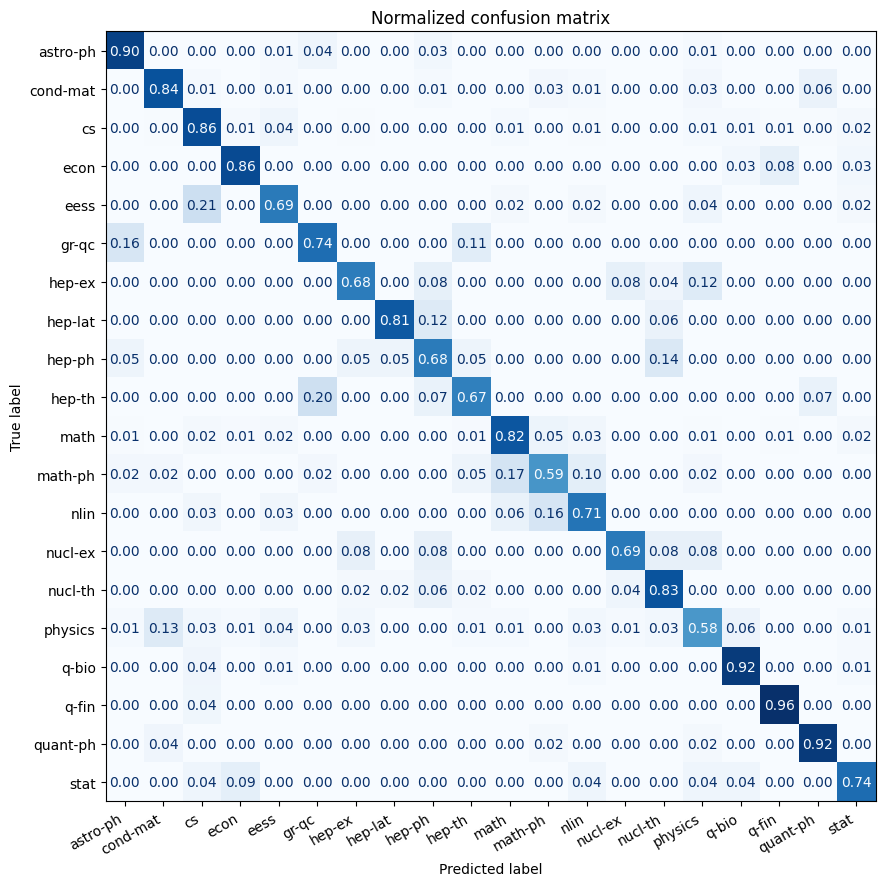

In [11]:
from src.utils import plot_confusion_matrix
from sklearn.svm import LinearSVC

svm_clf = LinearSVC(class_weight="balanced", random_state=42)
svm_clf.fit(X_train_embed, y_train)
y_preds = svm_clf.predict(X_valid_embed)

plot_confusion_matrix(y_preds, y_valid, labels)


In [12]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, y_preds, target_names=labels))


              precision    recall  f1-score   support

    astro-ph       0.89      0.90      0.89        70
    cond-mat       0.83      0.84      0.83        80
          cs       0.95      0.86      0.90       474
        econ       0.74      0.86      0.80        37
        eess       0.52      0.69      0.59        48
       gr-qc       0.67      0.74      0.70        19
      hep-ex       0.71      0.68      0.69        25
     hep-lat       0.87      0.81      0.84        16
      hep-ph       0.56      0.68      0.61        22
      hep-th       0.53      0.67      0.59        15
        math       0.90      0.82      0.86       192
     math-ph       0.56      0.59      0.57        41
        nlin       0.54      0.71      0.61        31
     nucl-ex       0.64      0.69      0.67        13
     nucl-th       0.83      0.83      0.83        48
     physics       0.67      0.58      0.62        71
       q-bio       0.86      0.92      0.89        77
       q-fin       0.79    